In [7]:
import dlib
import cv2
import numpy as np
import matplotlib.pyplot as plt
from math import hypot

In [8]:
def extract_frames(video_path):
  video=cv2.VideoCapture(video_path)
  frame_array=[]
  fps = video.get(cv2.CAP_PROP_FPS)
  frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
  duration = frame_count/fps
  
  while True:
     grabbed, frame = video.read()
     if not grabbed:
         break
     frame_array.append(frame)
  return frame_array,fps,frame_count,duration

In [9]:
def display_all_frames(frame_array):
  for i in range(len(frame_array)):
    plt.imshow(frame_array[i])
    plt.show()

In [10]:
def read_captured_image(image_path):
  bgr_image=cv2.imread(image_path,cv2.IMREAD_COLOR)
  rgb_image=cv2.cvtColor(bgr_image,cv2.COLOR_BGR2RGB)
  plt.imshow(rgb_image)
  plt.show()
  return rgb_image

In [22]:
def get_boundries(image):
  frame=image.copy()
  gray=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
  detector=dlib.get_frontal_face_detector()
  predictor=dlib.shape_predictor("/content/drive/MyDrive/datasets/shape_predictor_68_face_landmarks.dat")
  faces=detector(gray)
  
  for face in faces:
    
    landmarks=predictor(gray,face)
    left_corner=(landmarks.part(48).x,landmarks.part(48).y)
    right_corner=(landmarks.part(54).x,landmarks.part(54).y)
    upper_lip=(landmarks.part(33).x,landmarks.part(33).y) #lower point of nose inorder the filter to fit exactly 
    lower_lip=(landmarks.part(57).x,landmarks.part(57).y)
    height=hypot(upper_lip[0]-lower_lip[0],upper_lip[1]-lower_lip[1])
    width=hypot(left_corner[0]-right_corner[0],left_corner[1]-right_corner[1])
    #print("WIDTH",width)
    #print("HEIGHT",height)
    x1=left_corner[0]
    y1=upper_lip[1]
    x2=right_corner[0]
    y2=lower_lip[1]
    #to plot the points on face #debugging of code
    """color=np.random.uniform([255,255,255],3)
    cv2.circle(frame,(lower_lip[0],lower_lip[1]),0,color,10)
    cv2.circle(frame,(upper_lip[0],upper_lip[1]),0,color,10)
    cv2.circle(frame,(left_corner[0],left_corner[1]),0,color,10)
    cv2.circle(frame,(right_corner[0],right_corner[1]),0,color,10)
    plt.imshow(frame)
    plt.show()
    print("kiran")"""
    if(height>90):#change the value on your need
      #print(True,width,height,(x1,y1),(x2,y2))
      return True,width,height,x1,y1,x2,y2
  else:
      return False,None,None,None,None,None,None


In [13]:
def filter_settings(frame,lipstick_filter,width,height,x1,y1,x2,y2):
  mouth_area=frame[y1:y2,x1:x2]
  #print(mouth_area.shape)
  mouth_height=mouth_area.shape[0]
  mouth_width=mouth_area.shape[1]
  
  #resize the lipstick filter based on the mouth area captured
  lipstick_filter1=cv2.resize(lipstick_filter,(mouth_width,mouth_height))
  lipstick_filter1=cv2.resize(lipstick_filter,(mouth_width,mouth_height))
  lipstick_filter1=cv2.cvtColor(lipstick_filter1,cv2.COLOR_RGB2GRAY)
  
  #threshold the fitler so we get rid of background
  _,mouth_mask=cv2.threshold(lipstick_filter1,170,255,cv2.THRESH_BINARY) 

  #mouth_mask=cv2.cvtColor(mouth_mask,cv2.COLOR_GRAY2RGB)
  mouth_masked_area=cv2.bitwise_and(mouth_area,mouth_area,mask=mouth_mask)
  
  
  lipstick_filter1=cv2.cvtColor(lipstick_filter1,cv2.COLOR_GRAY2RGB)
  
  #final_mouth=cv2.addWeighted(mouth_masked_area,0.9,lipstick_filter1,0.1,0)
  lipstick_filter2=cv2.resize(lipstick_filter,(mouth_width,mouth_height))
  
  #add  the mouth_masked_area and filter 
  final_mouth=mouth_masked_area+lipstick_filter2
  
  #replace the initally cropped area with the proccessed image
  frame[y1:y2,x1:x2]=final_mouth
  
  return frame

In [19]:
#if input passed as image
def image_main_function(image_path,filter_path):
  image=read_captured_image(image_path)
  flag,width,height,x1,y1,x2,y2=get_boundries(image)
  print(flag,width,height,x1,y1,x2,y2)
  if(flag):
    filter=cv2.imread(filter_path,cv2.IMREAD_COLOR)
    filter=cv2.cvtColor(filter,cv2.COLOR_BGR2RGB)
    plt.imshow(filter)
    plt.show()
    final_image=filter_settings(image,filter,width,height,x1,y1,x2,y2)
    plt.imshow(final_image)
    plt.show()


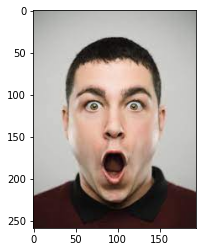

True 33.0 55.0 79 153 112 208


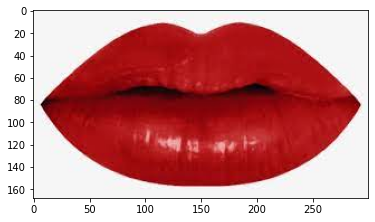

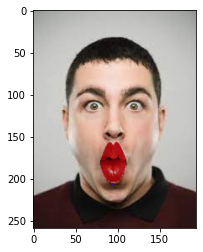

In [20]:

image_path="/content/download.jfif"
filter_path="/content/images.jfif"
image_main_function(image_path,filter_path)

In [21]:
#if input passed as video
def video_main_function(video_path,filter_path):
  
  frame_array,fps,frame_count,duration=extract_frames(video_path)
  filter=cv2.imread(filter_path,cv2.IMREAD_COLOR)
  filter=cv2.cvtColor(filter,cv2.COLOR_BGR2RGB)
  output_array=[]
  
  print(frame_count)
  for i in range(frame_count):
    x=frame_array[i]
    flag,width,height,x1,y1,x2,y2=get_boundries(x)
    if(flag):
      res=filter_settings(x,filter,width,height,x1,y1,x2,y2)
      output_array.append(res)
    else:
      output_array.append(x)
  #display_all_frames(output_array)
  video_writer(output_array,fps)

In [23]:
def video_writer(frame_array,fps):
  width=frame_array[1].shape[1]
  height=frame_array[1].shape[0]
  out = cv2.VideoWriter('diff1.avi',cv2.VideoWriter_fourcc('M','J','P','G'), fps, (width,height))
  for x in frame_array:
    out.write(x)
  out.release()
  cv2.destroyAllWindows()

In [38]:
video_path="/content/lip_sink video.mp4"
filter_path="/content/images.jfif"
video_main_function(video_path,filter_path)

150


In [ ]:
#below code is for debugging

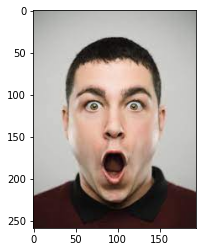

In [ ]:
#debugged code
image=read_captured_image("/content/download.jfif")
flag,width,height,x1,y1,x2,y2=get_boundries(image)

mouth_area


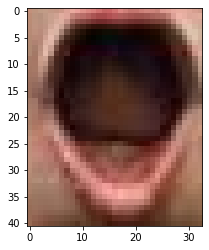

resized lipstick filter


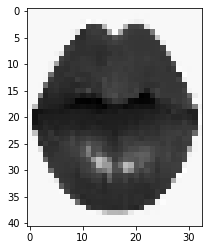

mouth masked area


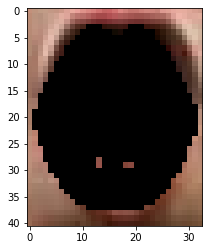

lipstick_filter1


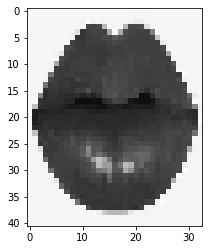

(41, 33, 3)
(41, 33, 3)
lipstick_filter2


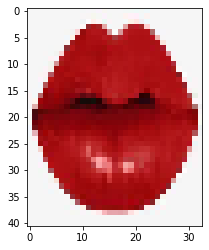

final_mouth


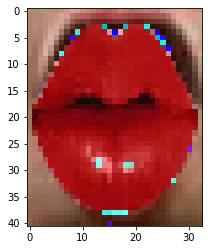

final output image


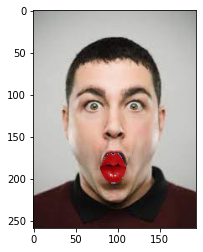

In [ ]:
filter=cv2.imread("/content/images.jfif",cv2.IMREAD_COLOR)
filter=cv2.cvtColor(filter,cv2.COLOR_BGR2RGB)
"""plt.imshow(filter)
plt.show()
plt.imshow(image)
plt.show()"""
filter_settings(image.copy(),filter.copy(),width,height,x1,y1,x2,y2)

In [2]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
import ffmpeg    

def check_rotation(path_video_file):
     # this returns meta-data of the video file in form of a dictionary
     meta_dict = ffmpeg.probe(path_video_file)

     # from the dictionary, meta_dict['streams'][0]['tags']['rotate'] is the key
     # we are looking for
     rotateCode = None
     if int(meta_dict['streams'][0]['tags']['rotate']) == 90:
         rotateCode = cv2.ROTATE_90_CLOCKWISE
     elif int(meta_dict['streams'][0]['tags']['rotate']) == 180:
         rotateCode = cv2.ROTATE_180
     elif int(meta_dict['streams'][0]['tags']['rotate']) == 270:
         rotateCode = cv2.ROTATE_90_COUNTERCLOCKWISE

     return rotateCode

In [ ]:
def correct_rotation(frame, rotateCode):  
     return cv2.rotate(frame, rotateCode) 

In [8]:
def filter_settings1(frame,lipstick_filter,width,height,x1,y1,x2,y2):
  mouth_area=frame[y1:y2,x1:x2]
  #print(mouth_area.shape)
  mouth_height=mouth_area.shape[0]
  mouth_width=mouth_area.shape[1]
  """print("mouth_area")
  plt.imshow(mouth_area)
  plt.show()"""
  lipstick_filter1=cv2.resize(lipstick_filter,(mouth_width,mouth_height))
  lipstick_filter1=cv2.resize(lipstick_filter,(mouth_width,mouth_height))
  lipstick_filter1=cv2.cvtColor(lipstick_filter1,cv2.COLOR_RGB2GRAY)
  """print("resized lipstick filter")
  plt.imshow(lipstick_filter1,cmap="gray")
  plt.show()"""
  #threshold needs gray scale image
  _,mouth_mask=cv2.threshold(lipstick_filter1,170,255,cv2.THRESH_BINARY)
  #mouth_mask=cv2.cvtColor(mouth_mask,cv2.COLOR_GRAY2RGB)
  mouth_masked_area=cv2.bitwise_and(mouth_area,mouth_area,mask=mouth_mask)
  #mouth_masked_area=cv2.cvtColor(mouth_masked_area,cv2.COLOR_RGB2GRAY)
  #mouth_masked_area=cv2.cvtColor(mouth_masked_area,cv2.COLOR_GRAY2RGB)
  """print("mouth masked area")
  plt.imshow(mouth_masked_area)
  plt.show()"""
  lipstick_filter1=cv2.cvtColor(lipstick_filter1,cv2.COLOR_GRAY2RGB)
  """print("lipstick_filter1")
  plt.imshow(lipstick_filter1)
  plt.show()
  print(lipstick_filter1.shape)
  print(mouth_masked_area.shape)"""
  #final_mouth=cv2.addWeighted(mouth_masked_area,0.9,lipstick_filter1,0.1,0)
  lipstick_filter2=cv2.resize(lipstick_filter,(mouth_width,mouth_height))
  #lipstick_filter2[np.where((lipstick_filter2==[246,246,246]).all(axis=2))] = [0,0,0]
  #print(lipstick_filter2)
  """print("lipstick_filter2")
  plt.imshow(lipstick_filter2)
  plt.show()"""
  #final_mouth=cv2.add(mouth_masked_area,lipstick_filter2)
  #final_mouth=cv2.cvtColor(final_mouth,cv2.COLOR_GRAY2RGB)
  final_mouth=mouth_masked_area+lipstick_filter2
  """print("final_mouth")
  plt.imshow(final_mouth)
  plt.show()"""
  frame[y1:y2,x1:x2]=final_mouth
  """print("final output image")
  plt.imshow(frame)
  plt.show()"""
  return frame